In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
font = {'family':"IPAexGothic",
        'weight' : 'bold'}

mpl.rc('font', **font)

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
sample_submit = pd.read_csv("./data/sample_submit.csv")

# Data Shape

In [3]:
print("Training data:", train.shape)
print("Test data:", test.shape)

Training data: (31470, 17)
Test data: (31262, 16)


# Concat train and test
# 賃料 and ID are saved as target, total_id respectively

In [4]:
target = train["賃料"]
train = train.drop(columns=["賃料"])
total_data = pd.concat([train, test], ignore_index=True)
total_id = total_data["id"]
total_data = total_data.drop(columns="id")
total_data.shape

(62732, 15)

# Examine Missing Values

In [5]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
missing_values = missing_values_table(total_data)
missing_values

Your selected dataframe has 15 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
周辺環境,18673,29.8
契約期間,14101,22.5
駐車場,10643,17.0
放送・通信,6894,11.0
方角,5557,8.9
キッチン,1256,2.0
バス・トイレ,649,1.0
室内設備,155,0.2
所在階,1,0.0


# Convert 全角 to 半角

In [7]:
for column in total_data.columns:
    print(column)
    total_data[column] = total_data[column].str.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))

所在地
アクセス
間取り
築年数
方角
面積
所在階
バス・トイレ
キッチン
放送・通信
室内設備
駐車場
周辺環境
建物構造
契約期間


# 築年数

## This format is "%Y年%m"
## But there are entries with "新築"

In [8]:
total_data["築年数"] = total_data["築年数"].replace("新築", "0年0ヶ月")
df = total_data["築年数"].str.split("年", expand=True)
df[0] = df[0].astype(int)
df[1] = df[1].str.strip("ヶ月").astype(int)
total_data["築年数_月"] = df[0] * 12 + df[1]
total_data.drop(columns=["築年数"], inplace=True)

# 面積

## Just converts "%dm2" to float

In [9]:
total_data["面積"] = total_data["面積"].str.replace("m2", "").astype(np.float)

# 所在階

In [10]:
# fill nan with ""-999"
total_data["所在階"] = total_data["所在階"].fillna("-999")
# add "/" to entries without "/" for splitting
total_data["所在階"][~total_data["所在階"].str.contains("/")] = "/" + total_data["所在階"][~total_data["所在階"].str.contains("/")]
# Split
total_data["階建"] = total_data["所在階"].str.split("/", expand=True)[1]
total_data["所在階"] = total_data["所在階"].str.split("/", expand=True)[0]
# Remove "階" from 所在階
total_data["所在階"] = total_data["所在階"].str.replace("階", "")
# Split again
total_data["所在階_地下"] = total_data["所在階"].str.split("地下", expand=True)[1]
total_data["所在階"] = total_data["所在階"].str.split("地下", expand=True)[0]
total_data["所在階"] = total_data["所在階"].replace("", 0).astype(int)
total_data["所在階_地下"] = total_data["所在階_地下"].fillna(0).astype(int)
total_data["階建"] = total_data["階建"].str.replace("階建", "")
total_data["階建"] = total_data["階建"].str.replace("階", "")
total_data["階建_地下"] = total_data["階建"].str.split("(", expand=True)[1]
total_data["階建"] = total_data["階建"].str.split("(", expand=True)[0].astype(int)
total_data["階建_地下"] = total_data["階建_地下"].str.replace("地下", "").str.replace(")", "").fillna(0).astype(int)

/home/amar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
total_data.head(1)

,所在地,アクセス,間取り,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,築年数_月,階建,所在階_地下,階建_地下
0,東京都北区滝野川3丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,南東,20.01,1,専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t浴室乾燥機\t/\t温水洗浄便座,ガスコンロ/\tコンロ2口/\tシステムキッチン\t/\t給湯,インターネット対応/\tCATV/\tCSアンテナ/\tBSアンテナ,エアコン付\tシューズボックス/\tバルコニー/\tフローリング/\t室内洗濯機置場/\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC(鉄筋コンクリート),2年間,117,12,0,0


# 間取り

In [12]:
total_data["間取り"].unique()

array(['1K', '1R', '2LDK', '2DK', '1DK', '1LDK', '3LDK', '3DK',
       '1LDK+S(納戸)', '4K', '2K', '1K+S(納戸)', '4LDK', '3LDK+S(納戸)',
       '5LDK+S(納戸)', '5LDK', '3K', '4DK', '2LDK+S(納戸)', '2DK+S(納戸)',
       '4LDK+S(納戸)', '5DK', '3DK+S(納戸)', '1DK+S(納戸)', '5K', '6LDK',
       '2K+S(納戸)', '1LK+S(納戸)', '5DK+S(納戸)', '3K+S(納戸)', '8LDK',
       '6LDK+S(納戸)', '11R', '6K', '6DK', '4DK+S(納戸)', '2R', '1LK'],
      dtype=object)

In [13]:
total_data["納戸"] = total_data["間取り"].str.contains("納戸", regex=False)

In [14]:
total_data["間取り"] = total_data["間取り"].str.strip("(納戸)")
total_data["間取り"].unique()

array(['1K', '1R', '2LDK', '2DK', '1DK', '1LDK', '3LDK', '3DK', '1LDK+S',
       '4K', '2K', '1K+S', '4LDK', '3LDK+S', '5LDK+S', '5LDK', '3K',
       '4DK', '2LDK+S', '2DK+S', '4LDK+S', '5DK', '3DK+S', '1DK+S', '5K',
       '6LDK', '2K+S', '1LK+S', '5DK+S', '3K+S', '8LDK', '6LDK+S', '11R',
       '6K', '6DK', '4DK+S', '2R', '1LK'], dtype=object)

In [15]:
unique_keys = sorted(set(''.join(total_data["間取り"].unique())))
print(unique_keys)

['+', '1', '2', '3', '4', '5', '6', '8', 'D', 'K', 'L', 'R', 'S']


In [16]:
for char in ["D", "K", "L", "R", "S"]:
    new_col = "間取り" + "_" + char
    print(new_col)
    total_data[new_col] = total_data["間取り"].str.contains(char)

間取り_D
間取り_K
間取り_L
間取り_R
間取り_S


In [17]:
for char in ["D", "K", "L", "R", "S"]:
    new_col = "間取り" + "_" + char
    print(new_col)
    print(total_data[new_col].nunique())

間取り_D
2
間取り_K
2
間取り_L
2
間取り_R
2
間取り_S
2


In [18]:
total_data["間取り_数"] = total_data["間取り"].str.strip("DKLRS+").astype(int)

# 方角

In [19]:
total_data["方角"].unique()

array(['南東', nan, '南', '東', '北西', '西', '北', '南西', '北東'], dtype=object)

In [20]:
total_data["方角_南"] = total_data["方角"].str.contains("南")
total_data["方角_東"] = total_data["方角"].str.contains("東")
total_data["方角_西"] = total_data["方角"].str.contains("西")
total_data["方角_北"] = total_data["方角"].str.contains("北")

In [21]:
total_data.head()

,所在地,アクセス,間取り,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,...,間取り_D,間取り_K,間取り_L,間取り_R,間取り_S,間取り_数,方角_南,方角_東,方角_西,方角_北
0,東京都北区滝野川3丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,南東,20.01,1,専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t浴室乾燥機\t/\t温水洗浄便座,ガスコンロ/\tコンロ2口/\tシステムキッチン\t/\t給湯,インターネット対応/\tCATV/\tCSアンテナ/\tBSアンテナ,エアコン付\tシューズボックス/\tバルコニー/\tフローリング/\t室内洗濯機置場/\t敷...,...,False,True,False,False,False,1,True,True,False,False
1,東京都中央区月島3丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,NaN,16.50,5,専用トイレ/\tシャワー/\t温水洗浄便座,ガスコンロ/\tシステムキッチン\t/\t給湯,インターネット対応,エアコン付\tシューズボックス/\tバルコニー/\tフローリング/\t室内洗濯機置場/\t敷...,...,False,False,False,True,False,1,NaN,NaN,NaN,NaN
2,東京都渋谷区笹塚2丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,南,22.05,12,専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t浴室乾燥機\t/\t温水洗浄...,ガスコンロ/\tコンロ2口/\tシステムキッチン\t/\t給湯,インターネット対応/\t光ファイバー/\tCSアンテナ/\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス/\tバルコニー/\tフローリング...,...,False,True,False,False,False,1,True,False,False,False
3,東京都杉並区高円寺南2丁目23-2,総武線・中央線(各停)\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋-荻窪)\t新高円寺駅\...,2LDK,南,60.48,3,専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t温水洗浄便座/\t洗面台独立,ガスコンロ/\t給湯,インターネット対応/\t光ファイバー,エアコン付\tシューズボックス/\tバルコニー/\t2面採光/\t室内洗濯機置場/\tエレベ...,...,True,True,True,False,False,2,True,False,False,False
4,東京都葛飾区金町3丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,南,39.66,1,専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t追焚機能,給湯/\t独立キッチン,NaN,バルコニー/\tフローリング/\t室内洗濯機置場\t公営水道/\t下水,...,True,True,False,False,False,2,True,False,False,False


# 建物構造

## Fine the way it is

In [22]:
for i in total_data["建物構造"].unique():
    print(i)

RC(鉄筋コンクリート)
鉄骨造
木造
SRC(鉄骨鉄筋コンクリート)
軽量鉄骨
ALC(軽量気泡コンクリート)
その他
PC(プレキャスト・コンクリート(鉄筋コンクリート))
HPC(プレキャスト・コンクリート(重量鉄骨))
ブロック
鉄筋ブロック


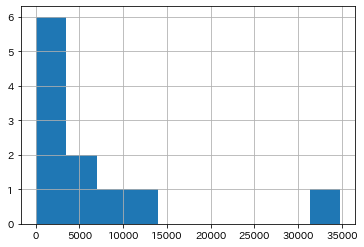

In [23]:
total_data["建物構造"].value_counts().hist()

# 契約期間

In [24]:
df = total_data["契約期間"].str.split("\t", expand=True)
df.head()

,0,1,2,3
0,2年間,None,None,None
1,2年間,None,None,None
2,2年間,None,None,None
3,2年間,※この物件は,定期借家,です。
4,2年間,None,None,None


In [25]:
for i in df[0].unique():
    print(i)

2年間
nan
1年間
5年間
3年間
2ヶ月間
4年間
2021年4月まで
2023年3月まで
2022年3月まで
2021年8月まで
1ヶ月間
2020年3月まで
2021年2月まで
22年間
12年間
2020年6月まで
4年8ヶ月間
2021年7月まで
2022年6月まで
2021年3月まで
2021年12月まで
3年3ヶ月間
2022年7月まで
2年6ヶ月間
2022年2月まで
1年10ヶ月間
2023年8月まで
2020年5月まで
7年間
10年間
2021年1月まで
2019年12月まで
2021年9月まで
6年間
2023年10月まで
5年7ヶ月間
2024年3月まで
2020年8月まで
2年4ヶ月間
2022年5月まで
2024年9月まで
4年9ヶ月間
9ヶ月間
6ヶ月間
2020年7月まで
2020年2月まで
1年8ヶ月間
1年5ヶ月間
4年6ヶ月間
3年9ヶ月間
2021年5月まで
2021年6月まで
2020年12月まで
2023年2月まで
2024年2月まで
1年6ヶ月間
2020年1月まで
2022年9月まで
15年間
2022年8月まで
4年7ヶ月間
2025年8月まで
10ヶ月間
4年4ヶ月間
2024年4月まで
7ヶ月間
2025年2月まで
2019年11月まで
2020年11月まで
2023年12月まで
2年1ヶ月間
2023年7月まで


In [26]:
for i in df[3].unique():
    print(i)

None
です。
nan


In [27]:
total_data["契約期間_定期借家"] = total_data["契約期間"].str.split("\t", expand=True)[2].replace("定期借家", 1).fillna(0).astype(int)

In [28]:
total_data["契約期間"] = total_data["契約期間"].str.split("\t", expand=True)[0]
total_data["契約期間"] = total_data["契約期間"].str.replace("ヶ", "")

In [29]:
total_data["契約期間"] = total_data["契約期間"].fillna("0年間")
total_data["契約期間"][total_data["契約期間"].str.contains("年間", regex=False)] = (total_data["契約期間"][total_data["契約期間"].str.contains("年間", regex=False)].str.replace("年間", "").astype(int)+2019).astype(str)+"年8月まで"
total_data["契約期間"][~total_data["契約期間"].str.contains("年")] = "年" + total_data["契約期間"][~total_data["契約期間"].str.contains("年")]
temp_df = total_data["契約期間"][total_data["契約期間"].str.contains("月間", regex=False)].str.replace("月間", "").str.split("年", expand=True)
temp_df[1] = temp_df[1].astype(int) + 8
temp_df[0] = 2019 + temp_df[0].replace("", "0").astype(int)
temp_df[0][temp_df[1] > 12] = temp_df[0][temp_df[1] > 12] + 1
temp_df[1][temp_df[1] > 12] = temp_df[1][temp_df[1] > 12] - 12
total_data["契約期間"][total_data["契約期間"].str.contains("月間", regex=False)] = temp_df[0].astype(str)+ "年" + temp_df[1].astype(str) + "月まで"
total_data["契約期間"].unique()

/home/amar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/amar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/amar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array(['2021年8月まで', '2019年8月まで', '2020年8月まで', '2024年8月まで', '2022年8月まで',
       '2019年10月まで', '2023年8月まで', '2021年4月まで', '2023年3月まで', '2022年3月まで',
       '2019年9月まで', '2020年3月まで', '2021年2月まで', '2041年8月まで', '2031年8月まで',
       '2020年6月まで', '2024年4月まで', '2021年7月まで', '2022年6月まで', '2021年3月まで',
       '2021年12月まで', '2022年11月まで', '2022年7月まで', '2022年2月まで', '2021年6月まで',
       '2020年5月まで', '2026年8月まで', '2029年8月まで', '2021年1月まで', '2019年12月まで',
       '2021年9月まで', '2025年8月まで', '2023年10月まで', '2025年3月まで', '2024年3月まで',
       '2022年5月まで', '2024年9月まで', '2024年5月まで', '2020年2月まで', '2020年7月まで',
       '2024年2月まで', '2023年5月まで', '2021年5月まで', '2020年12月まで', '2023年2月まで',
       '2020年1月まで', '2022年9月まで', '2034年8月まで', '2023年12月まで', '2025年2月まで',
       '2019年11月まで', '2020年11月まで', '2023年7月まで'], dtype=object)

In [30]:
total_data["契約期間"] = pd.to_datetime(total_data["契約期間"], format="%Y年%m月まで")
total_data["契約期間_月"] = (total_data["契約期間"].dt.year - 2019)*12 + total_data["契約期間"].dt.month - 8

# 所在地

In [31]:
total_data["所在地"] = total_data["所在地"].str.replace("東京都", "")
total_data["所在地_区"] = total_data["所在地"].str.split("区", expand=True)[0]

In [32]:
total_data["所在地"] = total_data["所在地"].str.split("区", expand=True)[1]

In [33]:
total_data["所在地"].value_counts()

日本橋馬喰町2丁目4-12     116
太子堂2丁目            106
板橋3丁目1-8          102
白鷺2丁目1-21          92
南長崎5丁目             85
本町4丁目              83
日本橋馬喰町2丁目          79
勝どき6丁目             77
江古田3丁目14-3         75
東池袋2丁目             74
池袋3丁目              71
海辺                 71
高島平1丁目             70
新田1丁目              69
勝どき6丁目3-2          68
三筋1丁目              68
栗原3丁目              66
笹塚2丁目              66
東雲1丁目              66
鹿骨5丁目              64
本町1丁目              64
南大塚3丁目             63
港南3丁目7-3           63
滝野川6丁目             62
緑4丁目               62
堀ノ内3丁目             62
方南1丁目              61
浅草3丁目              60
本町5丁目              59
高円寺南3丁目            59
                 ... 
仲池上1丁目1-15          1
栄町18-8              1
栄町13-6              1
細田4丁目42-2           1
給田4丁目27-6           1
高島平8丁目27-3          1
駒込2丁目6-5            1
阿佐谷北2丁目21-11        1
恵比寿4丁目7-2           1
六町3丁目7-12           1
久が原4丁目24-20         1
若宮1丁目8-19           1
西ケ原4丁目61-12         1
代田3丁目55-16          1
新町2丁目23-22

# アクセス

In [34]:
df = total_data["アクセス"].str.split("\t", expand=True)

In [35]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,都営三田線,西巣鴨駅,徒歩4分,,埼京線,板橋駅,徒歩14分,,都電荒川線,西ケ原四丁目駅,徒歩7分,None,None
1,都営大江戸線,勝どき駅,徒歩5分,,有楽町線,月島駅,徒歩9分,,日比谷線,築地駅,徒歩20分,None,None
2,京王線,笹塚駅,徒歩6分,,京王線,代田橋駅,徒歩7分,,京王線,明大前駅,徒歩17分,None,None
3,総武線・中央線(各停),高円寺駅,徒歩9分,,丸ノ内線(池袋-荻窪),新高円寺駅,徒歩3分,,丸ノ内線(池袋-荻窪),東高円寺駅,徒歩14分,None,None
4,京成金町線,京成金町駅,徒歩5分,,常磐線,金町(東京都)駅,徒歩7分,,京成金町線,柴又駅,徒歩17分,None,None
5,常磐線快速,南千住駅,徒歩2分,,都電荒川線,三ノ輪橋駅,徒歩10分,,日比谷線,三ノ輪駅,徒歩10分,None,None
6,西武池袋線,大泉学園駅,徒歩4分,,西武池袋線,保谷駅,徒歩25分,,東武東上線,和光市駅,/バス(23分)大泉学園駅北口下車徒歩1分,None,None
7,東急東横線,学芸大学駅,徒歩7分,,東急東横線,都立大学駅,徒歩16分,,東急東横線,祐天寺駅,徒歩20分,None,None
8,南北線,東大前駅,徒歩3分,,都営三田線,白山(東京都)駅,徒歩10分,,千代田線,根津駅,徒歩12分,None,None
9,埼京線,板橋駅,徒歩8分,,都営三田線,新板橋駅,徒歩4分,,東武東上線,下板橋駅,徒歩7分,None,None


## df[0]

In [36]:
def print_unique(series):
    for i in series.unique():
        print(i)
print_unique(df[0])

都営三田線
都営大江戸線
京王線
総武線・中央線(各停)
京成金町線
常磐線快速
西武池袋線
東急東横線
南北線
埼京線
都営浅草線
京成本線
銀座線
中央線(快速)
京王新線
東武東上線
都営新宿線
半蔵門線
西武新宿線
有楽町線
京浜東北線
つくばエクスプレス
小田急小田原線
副都心線
東西線
東急大井町線
常磐線
山手線
東急池上線
日比谷線
京成押上線
東武スカイツリーライン
東急田園都市線
京急本線
東急目黒線
千代田線
丸ノ内線(中野坂上-方南町)
日暮里・舎人ライナー
京王井の頭線
丸ノ内線(池袋-荻窪)
東武亀戸線
東急多摩川線
ゆりかもめ
都電荒川線
東急世田谷線
北総線
総武本線
東海道新幹線
京葉線(東京-蘇我)
高崎線
西武豊島線
京急空港線
横須賀線
りんかい線
西武有楽町線
東武大師線
東武伊勢崎線(押上-曳舟)
東北本線(宇都宮線)
東京モノレール羽田線
東海道本線
湘南新宿ライン(東北本線-横須賀線)
湘南新宿ライン(高崎線-東海道本線)
東北新幹線
京成成田空港線
中央本線(東京-松本)
埼玉高速鉄道線


In [37]:
total_data["アクセス_線_1"] = df[0]

## df[1]

In [38]:
df[1][df[1].str.contains("駅")].shape

(62732,)

In [39]:
df[1].shape

(62732,)

In [40]:
total_data["アクセス_駅_1"] = df[1]

## df[2]

In [41]:
df[2].unique()

array(['徒歩4分', '徒歩5分', '徒歩6分', '徒歩9分', '徒歩2分', '徒歩7分', '徒歩3分', '徒歩8分',
       '徒歩15分', '徒歩11分', '徒歩10分', '徒歩13分', '徒歩12分', '徒歩22分', '徒歩1分',
       '徒歩19分', '徒歩18分', '徒歩23分', '徒歩17分', '徒歩20分', '/バス(6分)都民農園下車徒歩1分',
       '徒歩14分', '/バス(19分)長久保下車徒歩2分', '徒歩24分', '徒歩16分',
       '/バス(7分)大泉風致地区下車徒歩5分', '徒歩29分', '徒歩37分', '徒歩21分',
       '/バス(10分)関町郵便局前下車徒歩1分', '/バス(16分)新小71\u3000農業試験場下車徒歩3分',
       '/バス(18分)土支田二丁目下車徒歩5分', '/バス(12分)比丘尼橋下車徒歩3分', '/バス(10分)団地入口下車徒歩3分',
       '/バス(5分)善福寺下車徒歩1分', '徒歩25分', '/バス(15分)ふれあいの家下車',
       '/バス(13分)水元そよかぜ園下車徒歩1分', '/バス(15分)水元4丁目下車徒歩28分',
       '/バス(25分)武蔵関駅下車徒歩7分', '/バス(15分)越後山下車徒歩4分', '徒歩27分', '徒歩28分',
       '徒歩33分', '/バス(9分)西長久保下車徒歩1分', '/バス(16分)亀26\u3000松江下車徒歩5分', '徒歩26分',
       '/バス(23分)葛飾車庫入口下車徒歩11分', '/バス(10分)大田文化の森下車徒歩3分',
       '/バス(18分)幸田小学校下車徒歩3分', '/バス(11分)水元そよかぜ園下車徒歩6分',
       '/バス(16分)佐野センター前下車徒歩34分', '/バス(15分)花畑団地下車徒歩10分',
       '/バス(15分)水元そよかぜ園下車徒歩2分', '/バス(12分)六木団地下車徒歩3分',
       '/バス(19分)大泉学園町八丁目下車徒歩2分', '/バス(18分)本木新道下車徒歩3分',
     

## df[3]

In [42]:
df[3].unique()

array(['', None], dtype=object)

## df[4]

In [43]:
print_unique(df[4])

埼京線
有楽町線
京王線
丸ノ内線(池袋-荻窪)
常磐線
都電荒川線
西武池袋線
東急東横線
都営三田線
都営浅草線
京成本線
千代田線
都営大江戸線
副都心線
都営新宿線
日比谷線
西武新宿線
京葉線(東京-蘇我)
京急本線
小田急小田原線
山手線
東西線
東急田園都市線
京成金町線
南北線
東急池上線
常磐線快速
東武スカイツリーライン
銀座線
つくばエクスプレス
東急大井町線
総武本線
None
丸ノ内線(中野坂上-方南町)
東急世田谷線
総武線・中央線(各停)
京王新線
京成押上線
京王井の頭線
京浜東北線
東急目黒線
ゆりかもめ
東武東上線
りんかい線
日暮里・舎人ライナー
東武伊勢崎線(押上-曳舟)
中央線(快速)
東急多摩川線
半蔵門線
東武亀戸線
北総線
東武大師線
京急空港線
西武有楽町線
高崎線
東京モノレール羽田線
西武豊島線
東北本線(宇都宮線)
東海道本線
横須賀線
埼玉高速鉄道線
湘南新宿ライン(東北本線-横須賀線)
京急大師線
三田線
京成成田空港線
ディズニーリゾートライン
東海道新幹線
小76/松本橋東詰　6分
南武線(川崎-立川)


### There is an abnormally formatted data at id=33518

In [44]:
total_data[df[4].str.contains("小76", regex=False).fillna(False)]

,所在地,アクセス,間取り,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,...,間取り_数,方角_南,方角_東,方角_西,方角_北,契約期間_定期借家,契約期間_月,所在地_区,アクセス_線_1,アクセス_駅_1
33518,南小岩1丁目,総武線・中央線(各停)\t小岩駅\t徒歩22分\t\t小76/松本橋東詰 6分,6LDK,NaN,119.18,0,バス・トイレ別/\tシャワー/\t追焚機能/\t温水洗浄便座/\t洗面台独立,IHコンロ\t/\tコンロ3口/\tシステムキッチン\t/\t給湯,光ファイバー,ウォークインクローゼット\tシューズボックス/\tバルコニー/\tルーフバルコニー\t/\t...,...,6,NaN,NaN,NaN,NaN,0,24,江戸川,総武線・中央線(各停),小岩駅


In [45]:
# 総武線・中央線(各停)\t小岩駅\t徒歩22分

In [46]:
df[4].iloc[33518]

'小76/松本橋東詰\u30006分'

In [47]:
df[4].iloc[33518] = None

In [48]:
print_unique(df[4])

埼京線
有楽町線
京王線
丸ノ内線(池袋-荻窪)
常磐線
都電荒川線
西武池袋線
東急東横線
都営三田線
都営浅草線
京成本線
千代田線
都営大江戸線
副都心線
都営新宿線
日比谷線
西武新宿線
京葉線(東京-蘇我)
京急本線
小田急小田原線
山手線
東西線
東急田園都市線
京成金町線
南北線
東急池上線
常磐線快速
東武スカイツリーライン
銀座線
つくばエクスプレス
東急大井町線
総武本線
None
丸ノ内線(中野坂上-方南町)
東急世田谷線
総武線・中央線(各停)
京王新線
京成押上線
京王井の頭線
京浜東北線
東急目黒線
ゆりかもめ
東武東上線
りんかい線
日暮里・舎人ライナー
東武伊勢崎線(押上-曳舟)
中央線(快速)
東急多摩川線
半蔵門線
東武亀戸線
北総線
東武大師線
京急空港線
西武有楽町線
高崎線
東京モノレール羽田線
西武豊島線
東北本線(宇都宮線)
東海道本線
横須賀線
埼玉高速鉄道線
湘南新宿ライン(東北本線-横須賀線)
京急大師線
三田線
京成成田空港線
ディズニーリゾートライン
東海道新幹線
南武線(川崎-立川)


In [49]:
total_data["アクセス_線_2"] = df[4]

## df[5]

In [50]:
df[5].unique()

array(['板橋駅', '月島駅', '代田橋駅', '新高円寺駅', '金町(東京都)駅', '三ノ輪橋駅', '保谷駅', '都立大学駅',
       '白山(東京都)駅', '新板橋駅', '馬込駅', '江戸川駅', '表参道駅', '南阿佐ケ谷駅', '両国(都営線)駅',
       '笹塚駅', '氷川台駅', '船堀駅', '四ツ谷駅', '茅場町駅', '野方駅', '湯島駅', '越中島駅', '平和島駅',
       '京成小岩駅', '東長崎駅', '仲御徒町駅', '北綾瀬駅', '一之江駅', '東北沢駅', '目白駅', '西葛西駅',
       '用賀駅', '国立競技場駅', 'お花茶屋駅', '石神井公園駅', '荒川一中前駅', '落合南長崎駅', '京成金町駅',
       '後楽園駅', '浅草駅', '西馬込駅', '千鳥町駅', '大泉学園駅', '南千住駅', '曳舟駅', '渋谷駅',
       '新江古田駅', '西新宿五丁目駅', '千歳烏山駅', '浅草(TX)駅', '駒沢大学駅', '緑が丘(東京都)駅',
       '錦糸町駅', '八丁堀(東京都)駅', '馬喰町駅', '本駒込駅', '大森町駅', '祖師ケ谷大蔵駅', None,
       '蓮沼駅', '青井駅', '石川台駅', '中野新橋駅', '町屋(東京メトロ)駅', '栄町(東京都)駅', '巣鴨新田駅',
       '瑞江駅', '西大島駅', '春日(東京都)駅', '梅島駅', '千駄木駅', '北赤羽駅', '東高円寺駅', '上町駅',
       '西ケ原駅', '地下鉄成増駅', '若林(東京都)駅', '広尾駅', '門前仲町駅', '池袋駅', '押上駅', '熊野前駅',
       '荻窪駅', '王子駅前駅', '青物横丁駅', '方南町駅', '京成曳舟駅', '水道橋駅', '大島(東京都)駅',
       '高井戸駅', '日暮里駅', '六町駅', '乃木坂駅', '青砥駅', '西巣鴨駅', '汐留駅', '要町駅', '上野毛駅',
       '板橋区役所前駅', '中野(東京都)駅', '西小山駅', '麻布十番駅', '王子神谷駅', '狛江駅',

In [51]:
df[5].str.contains("徒歩", regex=False).sum()

0

In [52]:
total_data["アクセス_駅_2"] = df[5]

# df[6]

In [53]:
df[6].nunique()

774

In [54]:
df[6].unique()

array(['徒歩14分', '徒歩9分', '徒歩7分', '徒歩3分', '徒歩10分', '徒歩25分', '徒歩16分', '徒歩4分',
       '徒歩11分', '徒歩12分', '徒歩21分', '徒歩30分', '徒歩6分', '徒歩15分', '徒歩23分',
       '徒歩8分', '徒歩18分', '徒歩2分', '徒歩20分', '徒歩19分', '徒歩13分', '徒歩5分', None,
       '徒歩28分', '徒歩24分', '徒歩17分', '/バス(20分)都民農園下車徒歩1分',
       '/バス(17分)長久保下車徒歩2分', '/バス(10分)東葛西八丁目下車徒歩34分',
       '/バス(10分)最寄りのバス停下車徒歩14分', '徒歩22分', '/バス(7分)三軒寺下車徒歩1分',
       '車5.2km(18分)', '徒歩31分', '徒歩26分', '徒歩27分', '/バス(5分)大泉北中学校入口下車徒歩7分',
       '/バス(15分)足立車検場下車徒歩2分', '徒歩1分', '徒歩42分', '/バス(15分)東小岩一丁目下車徒歩2分',
       '/バス(27分)石神井郵便局停留所下車徒歩7分', '/バス(15分)谷中中入口下車徒歩3分', '徒歩70分', '徒歩36分',
       '/バス(16分)土支田二丁目下車徒歩5分', '/バス(7分)上祖師谷4丁目下車徒歩2分', '徒歩37分',
       '/バス(10分)本州製紙裏門下車徒歩2分', '/バス(19分)新小岩1丁目下車徒歩8分', '徒歩33分',
       '/バス(18分)比丘尼橋下車徒歩3分', '/バス(5分)日産自動車前下車徒歩4分', '/バス(10分)中央図書館下車徒歩3分',
       '/バス(15分)大谷田下車徒歩2分', '徒歩29分', '/バス(4分)善福寺下車徒歩1分',
       '/バス(12分)谷原二丁目下車徒歩16分', '/バス(10分)鹿本橋下車徒歩6分', '徒歩32分',
       '/バス(13分)水元そよかぜ園下車徒歩1分', '/バス(15分)鹿骨五丁目下車徒歩7分',
       '/バス(21分)

## df[7]

In [55]:
df[7].nunique()

1

In [56]:
df[7].unique()

array(['', None], dtype=object)

## df[8] did up to this point. Let's see the feature importances to see if it's useful or not

In [57]:
df[8].nunique()

469

In [58]:
df[8].unique()

array(['都電荒川線', '日比谷線', '京王線', '丸ノ内線(池袋-荻窪)', '京成金町線', '東武東上線', '東急東横線',
       '千代田線', '東急池上線', None, '山手線渋谷駅徒歩18分', '都営新宿線', '丸ノ内線(中野坂上-方南町)',
       '都営浅草線', '中央線(快速)', '銀座線', '有楽町線', '京急本線', '総武線・中央線(各停)', '山手線',
       '京王井の頭線', '東京メトロ東西線高田馬場駅徒歩9分', '京成本線', '西武新宿線', '常磐線', '都営三田線',
       '東武スカイツリーライン', '東急多摩川線', '西武池袋線', '東武亀戸線', '半蔵門線', '西武有楽町線',
       '都営大江戸線', '小田急小田原線', '東急世田谷線', '東急目黒線', '京浜東北線', '東西線', '東武大師線',
       '東急田園都市線', '副都心線', '京成押上線', '日暮里・舎人ライナー', '南北線', '埼京線', 'ゆりかもめ',
       '総武本線', '京葉線(東京-蘇我)', '東急大井町線', '東北本線(宇都宮線)', 'つくばエクスプレス', '常磐線快速',
       '京葉線越中島駅徒歩13分', '北総線', '京王新線', '横須賀線', '東海道新幹線', '東急目黒線奥沢駅徒歩15分',
       '東京メトロ東西線茅場町駅徒歩8分', '東京モノレール羽田線', '東京メトロ南北線目黒駅徒歩8分',
       '亀29/新田\u30004分', '中央本線(東京-松本)', '京急空港線', '西武豊島線', 'りんかい線',
       '都営大江戸線六本木駅徒歩8分', '東武伊勢崎線(押上-曳舟)', '東急世田谷線世田谷駅徒歩10分',
       '都営大江戸線両国駅徒歩12分', '埼玉高速鉄道線', '高崎線', '東京臨海高速鉄道天王洲アイル駅徒歩14分',
       '東京メトロ日比谷線広尾駅徒歩12分', '京急大師線', '東京メトロ東西線中野駅徒歩15分',
       '東京メトロ南北線目黒駅徒歩6分', '東京メトロ千代田線西日暮里

In [59]:
total_data.columns

Index(['所在地', 'アクセス', '間取り', '方角', '面積', '所在階', 'バス・トイレ', 'キッチン', '放送・通信',
       '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間', '築年数_月', '階建', '所在階_地下', '階建_地下',
       '納戸', '間取り_D', '間取り_K', '間取り_L', '間取り_R', '間取り_S', '間取り_数', '方角_南',
       '方角_東', '方角_西', '方角_北', '契約期間_定期借家', '契約期間_月', '所在地_区', 'アクセス_線_1',
       'アクセス_駅_1', 'アクセス_線_2', 'アクセス_駅_2'],
      dtype='object')

# バス・トイレ

In [60]:
total_data["バス・トイレ"].nunique()

404

In [61]:
total_data["バス・トイレ"].unique()

array(['専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t浴室乾燥機\t/\t温水洗浄便座',
       '専用トイレ/\tシャワー/\t温水洗浄便座',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t浴室乾燥機\t/\t温水洗浄便座/\t洗面台独立/\t脱衣所',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t温水洗浄便座/\t洗面台独立',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t追焚機能',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t追焚機能/\t浴室乾燥機\t/\t温水洗浄便座/\t洗面台独立/\t脱衣所',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\t追焚機能/\t浴室乾燥機\t/\t温水洗浄便座/\t洗面台独立/\t脱衣所',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\t追焚機能/\t洗面台独立',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t洗面台独立', '専用トイレ',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t追焚機能/\t浴室乾燥機\t/\t温水洗浄便座/\t洗面台独立',
       'バス・トイレ別/\tシャワー/\t追焚機能', 'シャワー',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t洗面台独立/\t脱衣所',
       'バス・トイレ別/\tシャワー/\t浴室乾燥機\t/\t温水洗浄便座/\t洗面台独立/\t脱衣所',
       '専用バス/\tバス・トイレ別/\tシャワー/\t浴室乾燥機\t/\t温水洗浄便座/\t洗面台独立',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t追焚機能/\t洗面台独立/\t脱衣所',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー', '専用バス/\tシャワー',
       '専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t温水洗浄便座',
       'シャワー/\t追焚機能/\t浴室

In [62]:
df = total_data["バス・トイレ"].str.split("\t", expand=True)

In [63]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9
0,専用バス/,専用トイレ/,バス・トイレ別/,シャワー/,浴室乾燥機,/,温水洗浄便座,None,None,None
1,専用トイレ/,シャワー/,温水洗浄便座,None,None,None,None,None,None,None
2,専用バス/,専用トイレ/,バス・トイレ別/,シャワー/,浴室乾燥機,/,温水洗浄便座/,洗面台独立/,脱衣所,None


In [64]:
missing_values = missing_values_table(df)
missing_values

Your selected dataframe has 10 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
9,53618,85.5
8,44606,71.1
7,38393,61.2
6,31267,49.8
5,25964,41.4
4,20286,32.3
3,13506,21.5
2,6053,9.6
1,2989,4.8
0,649,1.0


In [65]:
for i in df.columns:
    df[i] = df[i].str.strip("/")

In [66]:
df[1].values

array(['専用トイレ', 'シャワー', '専用トイレ', ..., 'シャワー', '専用トイレ', '専用トイレ'],
      dtype=object)

In [67]:
list_1 = np.array([])
for i in df.columns:
    list_1 = np.append(list_1, df[i].values)

In [68]:
set(list_1)

{'',
 None,
 nan,
 'シャワー',
 'トイレなし',
 'バスなし',
 'バス・トイレ別',
 '共同トイレ',
 '共同バス',
 '専用トイレ',
 '専用バス',
 '洗面台独立',
 '浴室乾燥機',
 '温水洗浄便座',
 '脱衣所',
 '追焚機能'}

In [69]:
bath_toilet_list = ['シャワー',
 'バス・トイレ別',
 '共同トイレ',
 '共同バス',
 '専用トイレ',
 '専用バス',
 '洗面台独立',
 '浴室乾燥機',
 '温水洗浄便座',
 '脱衣所',
 '追焚機能']

In [70]:
bath_toilet_list

['シャワー',
 'バス・トイレ別',
 '共同トイレ',
 '共同バス',
 '専用トイレ',
 '専用バス',
 '洗面台独立',
 '浴室乾燥機',
 '温水洗浄便座',
 '脱衣所',
 '追焚機能']

In [71]:
for item in bath_toilet_list:
    total_data[item] = total_data["バス・トイレ"].str.contains(item, regex=False)

In [72]:
total_data.head()

,所在地,アクセス,間取り,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,...,バス・トイレ別,共同トイレ,共同バス,専用トイレ,専用バス,洗面台独立,浴室乾燥機,温水洗浄便座,脱衣所,追焚機能
0,滝野川3丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,南東,20.01,1,専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t浴室乾燥機\t/\t温水洗浄便座,ガスコンロ/\tコンロ2口/\tシステムキッチン\t/\t給湯,インターネット対応/\tCATV/\tCSアンテナ/\tBSアンテナ,エアコン付\tシューズボックス/\tバルコニー/\tフローリング/\t室内洗濯機置場/\t敷...,...,True,False,False,True,True,False,True,True,False,False
1,月島3丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,NaN,16.50,5,専用トイレ/\tシャワー/\t温水洗浄便座,ガスコンロ/\tシステムキッチン\t/\t給湯,インターネット対応,エアコン付\tシューズボックス/\tバルコニー/\tフローリング/\t室内洗濯機置場/\t敷...,...,False,False,False,True,False,False,False,True,False,False
2,笹塚2丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,南,22.05,12,専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t浴室乾燥機\t/\t温水洗浄...,ガスコンロ/\tコンロ2口/\tシステムキッチン\t/\t給湯,インターネット対応/\t光ファイバー/\tCSアンテナ/\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス/\tバルコニー/\tフローリング...,...,True,False,False,True,True,True,True,True,True,False
3,高円寺南2丁目23-2,総武線・中央線(各停)\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋-荻窪)\t新高円寺駅\...,2LDK,南,60.48,3,専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t温水洗浄便座/\t洗面台独立,ガスコンロ/\t給湯,インターネット対応/\t光ファイバー,エアコン付\tシューズボックス/\tバルコニー/\t2面採光/\t室内洗濯機置場/\tエレベ...,...,True,False,False,True,True,True,False,True,False,False
4,金町3丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,南,39.66,1,専用バス/\t専用トイレ/\tバス・トイレ別/\tシャワー/\t追焚機能,給湯/\t独立キッチン,NaN,バルコニー/\tフローリング/\t室内洗濯機置場\t公営水道/\t下水,...,True,False,False,True,True,False,False,False,False,True


In [73]:
total_data.columns

Index(['所在地', 'アクセス', '間取り', '方角', '面積', '所在階', 'バス・トイレ', 'キッチン', '放送・通信',
       '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間', '築年数_月', '階建', '所在階_地下', '階建_地下',
       '納戸', '間取り_D', '間取り_K', '間取り_L', '間取り_R', '間取り_S', '間取り_数', '方角_南',
       '方角_東', '方角_西', '方角_北', '契約期間_定期借家', '契約期間_月', '所在地_区', 'アクセス_線_1',
       'アクセス_駅_1', 'アクセス_線_2', 'アクセス_駅_2', 'シャワー', 'バス・トイレ別', '共同トイレ', '共同バス',
       '専用トイレ', '専用バス', '洗面台独立', '浴室乾燥機', '温水洗浄便座', '脱衣所', '追焚機能'],
      dtype='object')

# キッチン

In [74]:
total_data["キッチン"].nunique()

447

In [75]:
total_data["キッチン"].unique()

array(['ガスコンロ/\tコンロ2口/\tシステムキッチン\t/\t給湯', 'ガスコンロ/\tシステムキッチン\t/\t給湯',
       'ガスコンロ/\t給湯', '給湯/\t独立キッチン',
       'ガスコンロ/\tコンロ3口/\tシステムキッチン\t/\t給湯/\t独立キッチン',
       'ガスコンロ/\tコンロ2口/\tシステムキッチン', 'ガスコンロ/\tコンロ3口/\tシステムキッチン\t/\t給湯',
       'ガスコンロ/\tコンロ2口/\t給湯', nan, 'コンロ2口/\t給湯', '給湯',
       'IHコンロ\t/\tコンロ3口/\tシステムキッチン',
       'IHコンロ\t/\tコンロ3口/\tシステムキッチン\t/\t独立キッチン', 'ガスコンロ/\tコンロ1口/\t給湯',
       'ガスコンロ/\tコンロ1口/\t給湯/\t冷蔵庫あり',
       'ガスコンロ/\tコンロ2口/\tシステムキッチン\t/\t給湯/\t独立キッチン',
       'コンロ3口/\tシステムキッチン\t/\t給湯', 'IHコンロ\t/\tシステムキッチン\t/\t給湯',
       'コンロ設置可(コンロ2口)',
       'ガスコンロ/\tコンロ3口/\tシステムキッチン\t/\tカウンターキッチン\t/\t給湯/\tL字キッチン',
       'ガスコンロ/\tコンロ1口/\t給湯/\t独立キッチン',
       'ガスコンロ/\tコンロ3口/\tシステムキッチン\t/\tカウンターキッチン\t/\t給湯',
       'ガスコンロ/\tコンロ設置可(口数不明)/\t給湯',
       'ガスコンロ/\tコンロ2口/\t給湯/\t独立キッチン/\tL字キッチン', 'システムキッチン',
       'ガスコンロ/\tコンロ2口', '電気コンロ/\t給湯',
       'IHコンロ\t/\tコンロ2口/\tシステムキッチン\t/\t給湯/\tL字キッチン',
       'コンロ2口/\tシステムキッチン\t/\t給湯', 'コンロ2口/\tシステムキッチン\t/\t独立キッチン',
       'ガスコンロ/\tコンロ2口/\tシステム

In [76]:
df = total_data["キッチン"].str.split("\t", expand=True)

In [77]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9
0,ガスコンロ/,コンロ2口/,システムキッチン,/,給湯,None,None,None,None,None
1,ガスコンロ/,システムキッチン,/,給湯,None,None,None,None,None,None
2,ガスコンロ/,コンロ2口/,システムキッチン,/,給湯,None,None,None,None,None


In [78]:
missing_values = missing_values_table(df)
missing_values

Your selected dataframe has 10 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
9,62728,100.0
8,62603,99.8
7,61332,97.8
6,56404,89.9
5,48839,77.9
4,29466,47.0
3,22796,36.3
2,11779,18.8
1,5722,9.1
0,1256,2.0


In [79]:
for i in df.columns:
    df[i] = df[i].str.strip("/")

In [80]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9
0,ガスコンロ,コンロ2口,システムキッチン,,給湯,None,None,None,None,None
1,ガスコンロ,システムキッチン,,給湯,None,None,None,None,None,None
2,ガスコンロ,コンロ2口,システムキッチン,,給湯,None,None,None,None,None


In [81]:
list_1 = np.array([])
for i in df.columns:
    list_1 = np.append(list_1, df[i].values)

In [82]:
set(list_1)

{'',
 'IHコンロ',
 'L字キッチン',
 None,
 nan,
 'カウンターキッチン',
 'ガスコンロ',
 'コンロ1口',
 'コンロ2口',
 'コンロ3口',
 'コンロ4口以上',
 'コンロ設置可(コンロ1口)',
 'コンロ設置可(コンロ2口)',
 'コンロ設置可(コンロ3口)',
 'コンロ設置可(コンロ4口以上)',
 'コンロ設置可(口数不明)',
 'システムキッチン',
 '冷蔵庫あり',
 '独立キッチン',
 '給湯',
 '電気コンロ'}

In [83]:
kitchen_list = ['IHコンロ',
 'L字キッチン',
 'カウンターキッチン',
 'ガスコンロ',
 'コンロ1口',
 'コンロ2口',
 'コンロ3口',
 'コンロ4口以上',
 '口数不明',
 'システムキッチン',
 '冷蔵庫あり',
 '独立キッチン',
 '給湯',
 '電気コンロ']

In [84]:
for item in kitchen_list:
    total_data[item] = total_data["キッチン"].str.contains(item, regex=False)

In [85]:
total_data.columns

Index(['所在地', 'アクセス', '間取り', '方角', '面積', '所在階', 'バス・トイレ', 'キッチン', '放送・通信',
       '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間', '築年数_月', '階建', '所在階_地下', '階建_地下',
       '納戸', '間取り_D', '間取り_K', '間取り_L', '間取り_R', '間取り_S', '間取り_数', '方角_南',
       '方角_東', '方角_西', '方角_北', '契約期間_定期借家', '契約期間_月', '所在地_区', 'アクセス_線_1',
       'アクセス_駅_1', 'アクセス_線_2', 'アクセス_駅_2', 'シャワー', 'バス・トイレ別', '共同トイレ', '共同バス',
       '専用トイレ', '専用バス', '洗面台独立', '浴室乾燥機', '温水洗浄便座', '脱衣所', '追焚機能', 'IHコンロ',
       'L字キッチン', 'カウンターキッチン', 'ガスコンロ', 'コンロ1口', 'コンロ2口', 'コンロ3口', 'コンロ4口以上',
       '口数不明', 'システムキッチン', '冷蔵庫あり', '独立キッチン', '給湯', '電気コンロ'],
      dtype='object')

# 放送・通信

In [86]:
total_data["放送・通信"].nunique()

150

In [87]:
total_data["放送・通信"].unique()

array(['インターネット対応/\tCATV/\tCSアンテナ/\tBSアンテナ', 'インターネット対応',
       'インターネット対応/\t光ファイバー/\tCSアンテナ/\tBSアンテナ', 'インターネット対応/\t光ファイバー', nan,
       'インターネット対応/\t光ファイバー/\tCATV/\tBSアンテナ',
       '光ファイバー/\tCATV/\tCSアンテナ/\tBSアンテナ', '光ファイバー/\tCATV',
       'インターネット対応/\t光ファイバー/\tCATV/\tCSアンテナ/\tBSアンテナ', 'CATV',
       'インターネット対応/\t高速インターネット/\t光ファイバー/\tCATV/\tCSアンテナ/\tBSアンテナ',
       'インターネット対応/\t光ファイバー/\tCATV/\tCSアンテナ', '光ファイバー',
       '光ファイバー/\tインターネット使用料無料', '高速インターネット/\t光ファイバー/\tCATV',
       'インターネット対応/\t光ファイバー/\tCATV', '光ファイバー/\tCATV/\tBSアンテナ',
       '高速インターネット/\tCATV', 'インターネット対応/\tインターネット使用料無料',
       'インターネット対応/\t光ファイバー/\tインターネット使用料無料', 'インターネット対応/\tCATV',
       'インターネット対応/\tCSアンテナ/\tBSアンテナ/\tインターネット使用料無料',
       'インターネット対応/\tCSアンテナ/\tBSアンテナ', 'CSアンテナ/\tBSアンテナ',
       'インターネット対応/\tCATV/\tインターネット使用料無料',
       '光ファイバー/\tCATV/\tCSアンテナ/\tBSアンテナ/\tインターネット使用料無料',
       '高速インターネット/\t光ファイバー/\tCATV/\tCSアンテナ/\tBSアンテナ', 'CATV/\tBSアンテナ',
       'インターネット対応/\tBSアンテナ', 'BSアンテナ', 'インターネット対応/\tCATV/\t

In [88]:
df = total_data["放送・通信"].str.split("\t", expand=True)

In [89]:
for i in df.columns:
    df[i] = df[i].str.strip("/")

In [90]:
df.head(3)

,0,1,2,3,4,5,6
0,インターネット対応,CATV,CSアンテナ,BSアンテナ,None,None,None
1,インターネット対応,None,None,None,None,None,None
2,インターネット対応,光ファイバー,CSアンテナ,BSアンテナ,None,None,None


In [91]:
missing_values = missing_values_table(df)
missing_values

Your selected dataframe has 7 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
6,62529,99.7
5,60700,96.8
4,55355,88.2
3,45604,72.7
2,34281,54.6
1,19775,31.5
0,6894,11.0


In [92]:
list_1 = np.array([])
for i in df.columns:
    list_1 = np.append(list_1, df[i].values)

In [93]:
set(list_1)

{'BSアンテナ',
 'CATV',
 'CSアンテナ',
 None,
 nan,
 'インターネット使用料無料',
 'インターネット対応',
 '光ファイバー',
 '有線放送',
 '高速インターネット'}

In [94]:
network_list = ['BSアンテナ',
 'CATV',
 'CSアンテナ',
 'インターネット使用料無料',
 'インターネット対応',
 '光ファイバー',
 '有線放送',
 '高速インターネット']

In [95]:
for item in network_list:
    total_data[item] = total_data["放送・通信"].str.contains(item, regex=False)

In [96]:
total_data.columns

Index(['所在地', 'アクセス', '間取り', '方角', '面積', '所在階', 'バス・トイレ', 'キッチン', '放送・通信',
       '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間', '築年数_月', '階建', '所在階_地下', '階建_地下',
       '納戸', '間取り_D', '間取り_K', '間取り_L', '間取り_R', '間取り_S', '間取り_数', '方角_南',
       '方角_東', '方角_西', '方角_北', '契約期間_定期借家', '契約期間_月', '所在地_区', 'アクセス_線_1',
       'アクセス_駅_1', 'アクセス_線_2', 'アクセス_駅_2', 'シャワー', 'バス・トイレ別', '共同トイレ', '共同バス',
       '専用トイレ', '専用バス', '洗面台独立', '浴室乾燥機', '温水洗浄便座', '脱衣所', '追焚機能', 'IHコンロ',
       'L字キッチン', 'カウンターキッチン', 'ガスコンロ', 'コンロ1口', 'コンロ2口', 'コンロ3口', 'コンロ4口以上',
       '口数不明', 'システムキッチン', '冷蔵庫あり', '独立キッチン', '給湯', '電気コンロ', 'BSアンテナ', 'CATV',
       'CSアンテナ', 'インターネット使用料無料', 'インターネット対応', '光ファイバー', '有線放送', '高速インターネット'],
      dtype='object')

# 室内設備

In [97]:
total_data["室内設備"].nunique()

9293

In [98]:
total_data["室内設備"].unique()

array(['エアコン付\tシューズボックス/\tバルコニー/\tフローリング/\t室内洗濯機置場/\t敷地内ごみ置き場\t/\tエレベーター\t公営水道/\t下水/\t都市ガス',
       'エアコン付\tシューズボックス/\tバルコニー/\tフローリング/\t室内洗濯機置場/\t敷地内ごみ置き場\t/\tエレベーター/\tタイル張り',
       'エアコン付\tウォークインクローゼット\tシューズボックス/\tバルコニー/\tフローリング/\t室内洗濯機置場/\t敷地内ごみ置き場\t/\tエレベーター/\tタイル張り\t公営水道/\t下水/\t都市ガス',
       ..., 'エアコン付\tフローリング/\tペアガラス/\t室内洗濯機置場/\t敷地内ごみ置き場\t/\t専用庭',
       'エアコン付\tシューズボックス/\t出窓/\t室内洗濯機置場\t公営水道/\t下水/\t都市ガス',
       '冷房/\tエアコン付/\t床暖房\tバルコニー/\tフローリング/\t24時間換気システム\t/\t室内洗濯機置場/\t敷地内ごみ置き場\t/\tエレベーター/\tタイル張り\t公営水道/\t下水/\t都市ガス'],
      dtype=object)

In [99]:
df = total_data["室内設備"].str.split("\t", expand=True)
for i in df.columns:
    df[i] = df[i].str.strip("/")
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,エアコン付,シューズボックス,バルコニー,フローリング,室内洗濯機置場,敷地内ごみ置き場,,エレベーター,公営水道,下水,...,None,None,None,None,None,None,None,None,None,None
1,エアコン付,シューズボックス,バルコニー,フローリング,室内洗濯機置場,敷地内ごみ置き場,,エレベーター,タイル張り,None,...,None,None,None,None,None,None,None,None,None,None
2,エアコン付,ウォークインクローゼット,シューズボックス,バルコニー,フローリング,室内洗濯機置場,敷地内ごみ置き場,,エレベーター,タイル張り,...,None,None,None,None,None,None,None,None,None,None


In [100]:
missing_values = missing_values_table(df)
missing_values

Your selected dataframe has 23 columns.
There are 23 columns that have missing values.


,Missing Values,% of Total Values
22,62730,100.0
21,62729,100.0
20,62728,100.0
19,62711,100.0
18,62635,99.8
17,62333,99.4
16,61449,98.0
15,59266,94.5
14,54490,86.9
13,48546,77.4


In [101]:
list_1 = np.array([])
for i in df.columns:
    list_1 = np.append(list_1, df[i].values)

In [102]:
series = pd.Series(list_1)
list_1 = series.value_counts()
list_1

エアコン付           59257
室内洗濯機置場         54579
フローリング          54353
都市ガス            50802
バルコニー           49969
                49018
下水              46701
公営水道            46183
シューズボックス        45798
敷地内ごみ置き場        33275
エレベーター          32146
タイル張り           27130
24時間換気システム      21390
2面採光            13132
冷房              10474
ウォークインクローゼット     7547
室外洗濯機置場          3445
水道その他            3410
床暖房              3209
出窓               2536
ロフト付き            2458
3面採光             2160
プロパンガス           1971
ペアガラス            1252
床下収納             1198
オール電化            1128
トランクルーム          1028
クッションフロア          773
ルーフバルコニー          658
専用庭               438
バリアフリー            322
二重サッシ             178
洗濯機置場なし           132
防音室               120
ガスその他              35
浄化槽                18
排水その他              14
ガス暖房               13
汲み取り               11
地下室                10
二世帯住宅               4
井戸                  3
石油暖房                2
dtype: int64

In [103]:
list_1.index[:34].values

array(['エアコン付', '室内洗濯機置場', 'フローリング', '都市ガス', 'バルコニー', '', '下水', '公営水道',
       'シューズボックス', '敷地内ごみ置き場', 'エレベーター', 'タイル張り', '24時間換気システム', '2面採光',
       '冷房', 'ウォークインクローゼット', '室外洗濯機置場', '水道その他', '床暖房', '出窓', 'ロフト付き',
       '3面採光', 'プロパンガス', 'ペアガラス', '床下収納', 'オール電化', 'トランクルーム', 'クッションフロア',
       'ルーフバルコニー', '専用庭', 'バリアフリー', '二重サッシ', '洗濯機置場なし', '防音室'],
      dtype=object)

In [104]:
utilities_list = list_1.index[:34].values

In [105]:
set(utilities_list)

{'',
 '24時間換気システム',
 '2面採光',
 '3面採光',
 'ウォークインクローゼット',
 'エアコン付',
 'エレベーター',
 'オール電化',
 'クッションフロア',
 'シューズボックス',
 'タイル張り',
 'トランクルーム',
 'バリアフリー',
 'バルコニー',
 'フローリング',
 'プロパンガス',
 'ペアガラス',
 'ルーフバルコニー',
 'ロフト付き',
 '下水',
 '二重サッシ',
 '公営水道',
 '冷房',
 '出窓',
 '室内洗濯機置場',
 '室外洗濯機置場',
 '専用庭',
 '床下収納',
 '床暖房',
 '敷地内ごみ置き場',
 '水道その他',
 '洗濯機置場なし',
 '都市ガス',
 '防音室'}

In [106]:
utilities_list = ['24時間換気システム',
 '2面採光',
 '3面採光',
 'ウォークインクローゼット',
 'エアコン付',
 'エレベーター',
 'オール電化',
 'クッションフロア',
 'シューズボックス',
 'タイル張り',
 'トランクルーム',
 'バリアフリー',
 'バルコニー',
 'フローリング',
 'プロパンガス',
 'ペアガラス',
 'ルーフバルコニー',
 'ロフト付き',
 '下水',
 '二重サッシ',
 '公営水道',
 '冷房',
 '出窓',
 '室内洗濯機置場',
 '室外洗濯機置場',
 '専用庭',
 '床下収納',
 '床暖房',
 '敷地内ごみ置き場',
 '水道その他',
 '洗濯機置場なし',
 '都市ガス',
 '防音室']

In [107]:
len(utilities_list)

33

In [108]:
for item in utilities_list:
    total_data[item] = total_data["室内設備"].str.contains(item, regex=False)

In [109]:
total_data.columns[:20]

Index(['所在地', 'アクセス', '間取り', '方角', '面積', '所在階', 'バス・トイレ', 'キッチン', '放送・通信',
       '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間', '築年数_月', '階建', '所在階_地下', '階建_地下',
       '納戸', '間取り_D'],
      dtype='object')

# 駐車場

In [110]:
total_data["駐車場"].nunique()

5926

In [111]:
total_data["駐車場"].unique()

array(['駐輪場\t空有', '駐輪場\t空有\t駐車場\t無\tバイク置き場\t無',
       '駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m', ...,
       '駐車場\t空有\t12,960円\t距離10m\t駐輪場\t空有\tバイク置き場\t無',
       '駐車場\t空有\t32,400円\t(要空き確認)\t駐輪場\t空有\tバイク置き場\t空有',
       '駐車場\t空有\t21,600円\t(要確認)'], dtype=object)

In [112]:
df = total_data["駐車場"].str.split("\t", expand=True)
for i in df.columns:
    df[i] = df[i].str.strip("/")
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,駐輪場,空有,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,駐輪場,空有,駐車場,無,バイク置き場,無,None,None,None,None,None,None,None,None,None,None,None,None,None
2,駐輪場,空有,バイク置き場,空有,駐車場,近隣,"30,000円(税込)",距離100m,None,None,None,None,None,None,None,None,None,None,None


In [113]:
df[7].unique()

array([None, '距離100m', '無', nan, '距離150m', '空有', '距離200m', '距離500m',
       '距離300m', '0円', 'バイク置き場', '距離400m', '空有(1台)', '駐輪場', '23,000円',
       '距離125m', '25,000円', '■デザイナーズ物件', '近隣', '3,240円', '距離159m',
       '3,000円', '駐車場', '距離50m', '距離250m', '(中央2-36月極駐車場', '距離350m',
       '空有(2台)', '距離132m', '距離135m', '1,000円', '(平置駐)', '距離450m',
       '(※空き状況は都度確認が必要)', '距離160m', '距離260m', '月額)', '15120円/月額',
       '距離158m', '21,600円', '1ヶ月)', '(別途契約要)', '距離320m', '距離20m',
       '5,000円', '距離230m', '(自転車は無料で駐輪頂けます。(原付等バイクは有料))', '距離10m',
       '30,000円', '空有(4台)', '距離15m', '17,280円(税込)', '距離162m', '距離374m',
       '距離240m', '33,000円', '空無', '距離34m', '35,000円', '距離120m', '2,160円',
       '距離1000m', '距離5m', '(空き要確認・50cc迄)', '(2台目', '4,000円', '距離2m',
       '5,400円', '距離650m', '近隣(1台)', '1,000円(税抜)', '28,000円', '距離80m',
       '22,000円', '(空要確認)', '21,000円', '27,000円', '40,000円', '1ヶ月、敷金あり',
       '距離130m', '距離149m', '(月額制)', '26,000円', '(バイク(原付含む)駐輪不可)',
       '距離138m', '距離83m', '距離199m'

In [114]:
missing_values = missing_values_table(df)
missing_values

Your selected dataframe has 19 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
18,62731,100.0
17,62710,100.0
16,62710,100.0
15,62710,100.0
14,62710,100.0
13,62709,100.0
12,62696,99.9
11,62673,99.9
10,62602,99.8
9,62185,99.1


In [115]:
df[0].unique()

array(['駐輪場', '駐車場', nan, 'バイク置き場'], dtype=object)

In [116]:
list_1 = ['駐輪場', '駐車場', 'バイク置き場']
for item in list_1:
    total_data[item] = total_data["駐車場"].str.contains(item, regex=False)

In [117]:
df_1 = df[1].str.split("(", expand=True)

In [118]:
df_1[0].unique()

array(['空有', '無', '近隣', nan, '空無'], dtype=object)

In [119]:
list_1 = ['空有', '無', '近隣', '空無']
for item in list_1:
    total_data[item] = total_data["駐車場"].str.contains(item, regex=False)

In [120]:
df_1[1] = df_1[1].str.strip("台)")

In [121]:
df_1[1].unique()

array([None, nan, '1', '22', '3', '4', '2', '5', '11', '99', '6', '43',
       '8', '16', '15', '7', '27', '10', '13'], dtype=object)

In [122]:
df_1[1] = df_1[1].fillna("-999")
df_1[1] = df_1[1].astype(int)

In [123]:
df_1[1][df_1[1] == -999] = np.nan

/home/amar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [124]:
df_1[1].unique()

array([nan,  1., 22.,  3.,  4.,  2.,  5., 11., 99.,  6., 43.,  8., 16.,
       15.,  7., 27., 10., 13.])

In [125]:
total_data["駐車場_台数"] = df_1[1]

In [126]:
total_data["駐車場＿料金"] = df[2].where(df[2].str.contains("円") == True).str.strip("円()税込み抜き無初回登録料月額無料~:駐車場登録料").str.replace(",", "").str.replace("、", "").fillna(-999).astype(float)

In [127]:
total_data["駐車場＿料金"][total_data["駐車場＿料金"] == -999] = np.nan

/home/amar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [128]:
total_data["駐車場＿料金"]

0            NaN
1            NaN
2            NaN
3            NaN
4        17000.0
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10       32400.0
11           NaN
12           NaN
13           NaN
14           NaN
15       27000.0
16           NaN
17       15120.0
18           NaN
19           NaN
20           0.0
21           NaN
22           NaN
23           NaN
24       10000.0
25           0.0
26           NaN
27           NaN
28           NaN
29           NaN
          ...   
62702        NaN
62703        NaN
62704    35000.0
62705        NaN
62706        NaN
62707        NaN
62708        NaN
62709        NaN
62710        NaN
62711        NaN
62712        NaN
62713        NaN
62714        NaN
62715        NaN
62716        NaN
62717        NaN
62718        NaN
62719        NaN
62720        NaN
62721        NaN
62722        NaN
62723        NaN
62724    30000.0
62725        NaN
62726    30000.0
62727        NaN
62728    43200.0
62729    32400

In [129]:
total_data.columns[:20]

Index(['所在地', 'アクセス', '間取り', '方角', '面積', '所在階', 'バス・トイレ', 'キッチン', '放送・通信',
       '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間', '築年数_月', '階建', '所在階_地下', '階建_地下',
       '納戸', '間取り_D'],
      dtype='object')

# 周辺環境

In [130]:
total_data["周辺環境"].nunique()

32674

In [131]:
total_data["周辺環境"].unique()

array(['【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\t【飲食店】 378m\t【スーパー】 311m\t【コンビニ】 588m\t【スーパー】 1062m\t【ドラッグストア】 956m\t【郵便局】 1246m',
       '【スーパー】 1283m',
       '【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m', ...,
       '【飲食店】 460m\t【コンビニ】 410m\t【コンビニ】 257m\t【ドラッグストア】 432m\t【銀行】 312m\t【銀行】 409m\t【飲食店】 882m\t【飲食店】 882m\t【スーパー】 627m',
       '【スーパー】 283m\t【スーパー】 839m\t【コンビニ】 322m\t【コンビニ】 662m\t【ドラッグストア】 1168m',
       '【スーパー】 523m\t【スーパー】 696m\t【コンビニ】 381m\t【ドラッグストア】 769m'],
      dtype=object)

In [132]:
df = total_data["周辺環境"].str.split("\t", expand=True)
df.head(3)

,0,1,2,3,4,5,6,7,8,9
0,【小学校】 495m,【大学】 461m,【小学校】 962m,【公園】 1103m,【飲食店】 378m,【スーパー】 311m,【コンビニ】 588m,【スーパー】 1062m,【ドラッグストア】 956m,【郵便局】 1246m
1,【スーパー】 1283m,None,None,None,None,None,None,None,None,None
2,【スーパー】 89m,【コンビニ】 184m,【コンビニ】 392m,【スーパー】 492m,None,None,None,None,None,None


In [133]:
missing_values = missing_values_table(df)
missing_values

Your selected dataframe has 10 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
9,61238,97.6
8,59591,95.0
7,57790,92.1
6,54367,86.7
5,45139,72.0
4,35201,56.1
3,26700,42.6
2,22109,35.2
1,19646,31.3
0,18673,29.8


In [134]:
list_1 = np.array([])
for i in df.columns:
    list_1 = np.append(list_1, df[i].str.replace("\d+", "").str.strip("m").str.strip(" "))

In [135]:
series = pd.Series(list_1)
series.value_counts()

【スーパー】        81401
【コンビニ】        69790
【飲食店】         14105
【ドラッグストア】     11464
【病院】           7647
【公園】           7524
【郵便局】          6993
【小学校】          5305
【大学】           4161
【総合病院】         3822
【幼稚園・保育園】      3623
【学校】           3004
【銀行】           2650
【図書館】          2556
【デパート】         1458
【レンタルビデオ】      1018
【クリーニング】        287
【コインパーキング】       46
【月極駐車場】          12
dtype: int64

In [136]:
for item in series.value_counts().index.values:
    total_data[item] = total_data["周辺環境"].str.contains(item, regex=False)

In [137]:
total_data.columns[:20]

Index(['所在地', 'アクセス', '間取り', '方角', '面積', '所在階', 'バス・トイレ', 'キッチン', '放送・通信',
       '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間', '築年数_月', '階建', '所在階_地下', '階建_地下',
       '納戸', '間取り_D'],
      dtype='object')

# 建物構造

## fine as it is

In [138]:
total_data["建物構造"].nunique()

11

In [139]:
total_data["建物構造"].unique()

array(['RC(鉄筋コンクリート)', '鉄骨造', '木造', 'SRC(鉄骨鉄筋コンクリート)', '軽量鉄骨',
       'ALC(軽量気泡コンクリート)', 'その他', 'PC(プレキャスト・コンクリート(鉄筋コンクリート))',
       'HPC(プレキャスト・コンクリート(重量鉄骨))', 'ブロック', '鉄筋ブロック'], dtype=object)

# Add coordinates

In [140]:
train_lat = pd.read_csv("train_lat.csv", names=["緯度"])
train_lng = pd.read_csv("train_lng.csv", names=["経度"])
test_lat = pd.read_csv("test_lat.csv", names=["緯度"])
test_lng = pd.read_csv("test_lng.csv", names=["経度"])

In [141]:
lat = pd.concat([train_lat, test_lat], ignore_index=True)
lng = pd.concat([train_lng, test_lng], ignore_index=True)

In [142]:
lat.head()

,緯度
0,35.748456
1,35.662885
2,35.675153
3,35.700170
4,35.766431


In [143]:
lng.head()

,経度
0,139.728800
1,139.778627
2,139.666255
3,139.648465
4,139.872321


In [144]:
total_data["緯度"] = lat["緯度"]
total_data["経度"] = lng["経度"]

# Drop columns

In [145]:
for i in total_data.columns.values:
    print(i)

所在地
アクセス
間取り
方角
面積
所在階
バス・トイレ
キッチン
放送・通信
室内設備
駐車場
周辺環境
建物構造
契約期間
築年数_月
階建
所在階_地下
階建_地下
納戸
間取り_D
間取り_K
間取り_L
間取り_R
間取り_S
間取り_数
方角_南
方角_東
方角_西
方角_北
契約期間_定期借家
契約期間_月
所在地_区
アクセス_線_1
アクセス_駅_1
アクセス_線_2
アクセス_駅_2
シャワー
バス・トイレ別
共同トイレ
共同バス
専用トイレ
専用バス
洗面台独立
浴室乾燥機
温水洗浄便座
脱衣所
追焚機能
IHコンロ
L字キッチン
カウンターキッチン
ガスコンロ
コンロ1口
コンロ2口
コンロ3口
コンロ4口以上
口数不明
システムキッチン
冷蔵庫あり
独立キッチン
給湯
電気コンロ
BSアンテナ
CATV
CSアンテナ
インターネット使用料無料
インターネット対応
光ファイバー
有線放送
高速インターネット
24時間換気システム
2面採光
3面採光
ウォークインクローゼット
エアコン付
エレベーター
オール電化
クッションフロア
シューズボックス
タイル張り
トランクルーム
バリアフリー
バルコニー
フローリング
プロパンガス
ペアガラス
ルーフバルコニー
ロフト付き
下水
二重サッシ
公営水道
冷房
出窓
室内洗濯機置場
室外洗濯機置場
専用庭
床下収納
床暖房
敷地内ごみ置き場
水道その他
洗濯機置場なし
都市ガス
防音室
駐輪場
バイク置き場
空有
無
近隣
空無
駐車場_台数
駐車場＿料金
【スーパー】
【コンビニ】
【飲食店】
【ドラッグストア】
【病院】
【公園】
【郵便局】
【小学校】
【大学】
【総合病院】
【幼稚園・保育園】
【学校】
【銀行】
【図書館】
【デパート】
【レンタルビデオ】
【クリーニング】
【コインパーキング】
【月極駐車場】
緯度
経度


## Columns to remove

In [146]:
columns = ["所在地", "アクセス", "間取り", "方角", "バス・トイレ", "キッチン",
           "放送・通信", "室内設備", "駐車場", "周辺環境", "契約期間"]

In [147]:
total_data = total_data.drop(columns=columns)

# Model

# Impute NaNs

## Strategy: Mode

In [148]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62732 entries, 0 to 62731
Columns: 120 entries, 面積 to 経度
dtypes: bool(6), float64(10), int64(8), object(96)
memory usage: 54.9+ MB


In [149]:
total_data.select_dtypes("object").head(3)

,建物構造,方角_南,方角_東,方角_西,方角_北,所在地_区,アクセス_線_1,アクセス_駅_1,アクセス_線_2,アクセス_駅_2,...,【総合病院】,【幼稚園・保育園】,【学校】,【銀行】,【図書館】,【デパート】,【レンタルビデオ】,【クリーニング】,【コインパーキング】,【月極駐車場】
0,RC(鉄筋コンクリート),True,True,False,False,北,都営三田線,西巣鴨駅,埼京線,板橋駅,...,False,False,False,False,False,False,False,False,False,False
1,鉄骨造,NaN,NaN,NaN,NaN,中央,都営大江戸線,勝どき駅,有楽町線,月島駅,...,False,False,False,False,False,False,False,False,False,False
2,RC(鉄筋コンクリート),True,False,False,False,渋谷,京王線,笹塚駅,京王線,代田橋駅,...,False,False,False,False,False,False,False,False,False,False


In [150]:
total_data.mode()["方角_南"]

0    True
Name: 方角_南, dtype: object

In [151]:
total_data_filled = total_data.fillna(total_data.mode())

In [152]:
total_data_filled = total_data_filled.fillna(False)

In [153]:
total_data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62732 entries, 0 to 62731
Columns: 120 entries, 面積 to 経度
dtypes: bool(101), float64(3), int64(8), object(8)
memory usage: 15.1+ MB


In [154]:
total_data_filled["駐車場_台数"] = total_data_filled["駐車場_台数"].astype(float)
total_data_filled["駐車場＿料金"] = total_data_filled["駐車場＿料金"].astype(float)

In [155]:
total_data_filled.select_dtypes("object").head(10)

,建物構造,所在地_区,アクセス_線_1,アクセス_駅_1,アクセス_線_2,アクセス_駅_2
0,RC(鉄筋コンクリート),北,都営三田線,西巣鴨駅,埼京線,板橋駅
1,鉄骨造,中央,都営大江戸線,勝どき駅,有楽町線,月島駅
2,RC(鉄筋コンクリート),渋谷,京王線,笹塚駅,京王線,代田橋駅
3,RC(鉄筋コンクリート),杉並,総武線・中央線(各停),高円寺駅,丸ノ内線(池袋-荻窪),新高円寺駅
4,木造,葛飾,京成金町線,京成金町駅,常磐線,金町(東京都)駅
5,RC(鉄筋コンクリート),荒川,常磐線快速,南千住駅,都電荒川線,三ノ輪橋駅
6,RC(鉄筋コンクリート),練馬,西武池袋線,大泉学園駅,西武池袋線,保谷駅
7,RC(鉄筋コンクリート),目黒,東急東横線,学芸大学駅,東急東横線,都立大学駅
8,SRC(鉄骨鉄筋コンクリート),文京,南北線,東大前駅,都営三田線,白山(東京都)駅
9,鉄骨造,板橋,埼京線,板橋駅,都営三田線,新板橋駅


In [156]:
total_data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62732 entries, 0 to 62731
Columns: 120 entries, 面積 to 経度
dtypes: bool(101), float64(5), int64(8), object(6)
memory usage: 15.1+ MB


In [157]:
total_data_filled.select_dtypes("float").head(10)

,面積,駐車場_台数,駐車場＿料金,緯度,経度
0,20.01,1.0,0.0,35.748456,139.728800
1,16.50,0.0,0.0,35.662885,139.778627
2,22.05,0.0,0.0,35.675153,139.666255
3,60.48,0.0,0.0,35.700170,139.648465
4,39.66,0.0,17000.0,35.766431,139.872321
5,50.80,0.0,0.0,35.733822,139.795246
6,23.82,0.0,0.0,35.752992,139.587849
7,32.32,0.0,0.0,35.625996,139.686671
8,65.59,0.0,0.0,35.719499,139.755944
9,30.30,0.0,0.0,35.751231,139.718584


In [158]:
total_data_filled.select_dtypes("int").head(10)

,所在階,築年数_月,階建,所在階_地下,階建_地下,間取り_数,契約期間_定期借家,契約期間_月
0,1,117,12,0,0,1,0,24
1,5,538,10,0,0,1,0,24
2,12,102,15,0,0,1,0,24
3,3,352,4,0,0,2,1,24
4,1,379,2,0,0,2,0,24
5,6,90,12,0,0,2,0,24
6,6,125,8,0,0,1,0,24
7,1,172,6,0,0,1,0,24
8,4,536,9,0,0,2,0,24
9,2,465,3,0,0,1,0,24


In [159]:
total_data_filled.select_dtypes("bool").head(10)

,納戸,間取り_D,間取り_K,間取り_L,間取り_R,間取り_S,方角_南,方角_東,方角_西,方角_北,...,【総合病院】,【幼稚園・保育園】,【学校】,【銀行】,【図書館】,【デパート】,【レンタルビデオ】,【クリーニング】,【コインパーキング】,【月極駐車場】
0,False,False,True,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,True,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,True,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,True,True,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
9,False,True,True,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [160]:
column_names = total_data.columns.values

In [161]:
total_data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62732 entries, 0 to 62731
Columns: 120 entries, 面積 to 経度
dtypes: bool(101), float64(5), int64(8), object(6)
memory usage: 15.1+ MB


In [162]:
total_data_filled.select_dtypes("object")

,建物構造,所在地_区,アクセス_線_1,アクセス_駅_1,アクセス_線_2,アクセス_駅_2
0,RC(鉄筋コンクリート),北,都営三田線,西巣鴨駅,埼京線,板橋駅
1,鉄骨造,中央,都営大江戸線,勝どき駅,有楽町線,月島駅
2,RC(鉄筋コンクリート),渋谷,京王線,笹塚駅,京王線,代田橋駅
3,RC(鉄筋コンクリート),杉並,総武線・中央線(各停),高円寺駅,丸ノ内線(池袋-荻窪),新高円寺駅
4,木造,葛飾,京成金町線,京成金町駅,常磐線,金町(東京都)駅
5,RC(鉄筋コンクリート),荒川,常磐線快速,南千住駅,都電荒川線,三ノ輪橋駅
6,RC(鉄筋コンクリート),練馬,西武池袋線,大泉学園駅,西武池袋線,保谷駅
7,RC(鉄筋コンクリート),目黒,東急東横線,学芸大学駅,東急東横線,都立大学駅
8,SRC(鉄骨鉄筋コンクリート),文京,南北線,東大前駅,都営三田線,白山(東京都)駅
9,鉄骨造,板橋,埼京線,板橋駅,都営三田線,新板橋駅


Access 2 has "False" entries

In [163]:
total_data_filled["アクセス_線_2"][total_data_filled["アクセス_線_2"] == False]

61       False
72       False
151      False
185      False
219      False
225      False
229      False
236      False
287      False
338      False
350      False
361      False
403      False
404      False
413      False
426      False
433      False
442      False
452      False
457      False
464      False
465      False
471      False
473      False
474      False
484      False
487      False
498      False
499      False
503      False
         ...  
62209    False
62229    False
62234    False
62239    False
62262    False
62273    False
62302    False
62322    False
62346    False
62366    False
62395    False
62412    False
62431    False
62438    False
62453    False
62486    False
62496    False
62508    False
62512    False
62526    False
62560    False
62606    False
62623    False
62629    False
62635    False
62656    False
62683    False
62687    False
62693    False
62718    False
Name: アクセス_線_2, Length: 2985, dtype: object

In [164]:
total_data_filled["アクセス_線_2"][total_data_filled["アクセス_線_2"] == False] = "0"

/home/amar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [165]:
total_data_filled["アクセス_駅_2"][total_data_filled["アクセス_駅_2"] == False] = "0"

/home/amar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Label Encoding

In [166]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [167]:
for column in total_data_filled.select_dtypes("object").columns:
    print(column)
    total_data_filled[column] = le.fit_transform(total_data_filled[column])

建物構造
所在地_区
アクセス_線_1
アクセス_駅_1
アクセス_線_2
アクセス_駅_2


In [168]:
total_data_filled.head(5)

,面積,所在階,建物構造,築年数_月,階建,所在階_地下,階建_地下,納戸,間取り_D,間取り_K,...,【学校】,【銀行】,【図書館】,【デパート】,【レンタルビデオ】,【クリーニング】,【コインパーキング】,【月極駐車場】,緯度,経度
0,20.01,1,3,117,12,0,0,False,False,True,...,False,False,False,False,False,False,False,False,35.748456,139.728800
1,16.50,5,10,538,10,0,0,False,False,False,...,False,False,False,False,False,False,False,False,35.662885,139.778627
2,22.05,12,3,102,15,0,0,False,False,True,...,False,False,False,False,False,False,False,False,35.675153,139.666255
3,60.48,3,3,352,4,0,0,False,True,True,...,False,False,False,False,False,False,False,False,35.700170,139.648465
4,39.66,1,7,379,2,0,0,False,True,True,...,False,False,False,False,False,False,False,False,35.766431,139.872321


In [169]:
total_data_filled.select_dtypes("object").sum()

Series([], dtype: float64)

In [170]:
total_data_filled.shape

(62732, 120)

# Normalization

In [171]:
train.shape

(31470, 16)

In [172]:
test.shape

(31262, 16)

In [173]:
train.shape[0] + test.shape[0]

62732

In [174]:
total_data_filled.shape

(62732, 120)

In [175]:
target.shape

(31470,)

In [176]:
X_train = total_data_filled[:train.shape[0]]
y_train = target
print(X_train.shape)
print(y_train.shape)

(31470, 120)
(31470,)


In [177]:
X_test = total_data_filled[train.shape[0]:]
print(X_test.shape)

(31262, 120)


In [178]:
test.shape

(31262, 16)

# Training

In [179]:
import xgboost as xgb
model = xgb.XGBRegressor(n_jobs=-1,
                         max_depth=10,
                         n_estimators=1700,
                         learning_rate=0.05,
                         random_state=0,
                         gamma=0.3,
                         subsample=0.8,
                        reg_lambda=4,
                        eval_metric="rmse",
                        tree_method="gpu_hist")

In [180]:
# model.fit(X_train, y_train)

In [181]:
y_pred = model.predict(X_test)

XGBoostError: need to call fit or load_model beforehand

In [ ]:
smpsb_df = pd.read_csv("./data/sample_submit.csv", header=None)

In [ ]:
smpsb_df.shape

In [ ]:
y_pred.shape

In [ ]:
smpsb_df.head()

In [ ]:
smpsb_df[1] = y_pred

In [ ]:
smpsb_df.head()

In [ ]:
smpsb_df.to_csv("xgboost3.csv", index=None, header=None)

In [ ]:
# plot feature importance
from xgboost import plot_importance
plt.figure(figsize=(20, 10))
plot_importance(model, max_num_features=30)
plt.savefig("feature_importance_1.png")
plt.show()

In [ ]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)


In [ ]:
my_plot_importance(model, (20, 10), max_num_features=60)
plt.savefig("feature_importance_1.png")

# Hyperopt

In [182]:
from sklearn.model_selection import train_test_split
from hyperopt import tpe, hp, fmin
from sklearn.metrics import mean_squared_error

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [190]:
X_train.values

array([[41.04, 3, 3, ..., False, 35.7443702, 139.7786272],
       [15.56, 2, 10, ..., False, 35.7678472, 139.7727593],
       [64.33, 7, 4, ..., False, 35.748202, 139.7824618],
       ...,
       [48.44, 1, 4, ..., False, 35.7781362, 139.7304487],
       [14.85, 2, 3, ..., False, 35.6413054, 139.69049930000003],
       [42.28, 0, 10, ..., False, 35.7486, 139.6522237]], dtype=object)

In [191]:
y_train.values

array([111000,  54000, 140000, ..., 135000,  65000, 115000])

In [193]:
import os
os.environ['OMP_NUM_THREADS'] = "1"

In [194]:
from hpsklearn import HyperoptEstimator, xgboost_regression

In [197]:
estim = HyperoptEstimator(regressor=xgboost_regression('myXGB'), verbose=-1)

In [198]:
estim.fit(X_train.values, y_train.values)

Will use the last 0.2 portion of samples for validation
Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (20140, 120)
Transforming Xfit (20140, 120)                     
Transforming Xval (5036, 120)                      
Training learner XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.8890139042078656, colsample_bynode=1,
             colsample_bytree=0.568440056710402, gamma=0.002314443074501631,
             importance_type='gain', learning_rate=0.10780341591905461,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
             n_estimators=5200, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.001196420509187308,
             reg_lambda=1.5838537725553767, scale_pos_weight=1, seed=0,
             silent=None, subsample=0.5782191472704798, verbosity=1) on X/EX of dimension (20140, 120)
[03:41:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:line

In [199]:
print(estim.score(X_test, y_test))

Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (6294, 120)
Transforming Xfit (6294, 120)
0.4971694246942049


In [206]:
print(estim.best_model())

{'learner': XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.8890139042078656, colsample_bynode=1,
             colsample_bytree=0.568440056710402, gamma=0.002314443074501631,
             importance_type='gain', learning_rate=0.10780341591905461,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             n_estimators=5200, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.001196420509187308,
             reg_lambda=1.5838537725553767, scale_pos_weight=1, seed=0,
             silent=None, subsample=0.5782191472704798, verbosity=1), 'preprocs': (MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)),), 'ex_preprocs': ()}


In [202]:
y_pred = estim.predict(X_test)

Fitting MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)) to X of shape (6294, 120)
Transforming Xfit (6294, 120)


In [203]:
from sklearn.metrics import mean_squared_error

In [205]:
mean_squared_error(y_test, y_pred)**0.5

54296.24908825792

# Training

In [207]:
X_train = total_data_filled[:train.shape[0]]
y_train = target
print(X_train.shape)
print(y_train.shape)

(31470, 120)
(31470,)


In [208]:
X_test = total_data_filled[train.shape[0]:]
print(X_test.shape)

(31262, 120)


In [178]:
test.shape

(31262, 16)

# Scaling

In [218]:
feature_names = list(X_train.columns)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)
X_train.head()

,面積,所在階,建物構造,築年数_月,階建,所在階_地下,階建_地下,納戸,間取り_D,間取り_K,...,【学校】,【銀行】,【図書館】,【デパート】,【レンタルビデオ】,【クリーニング】,【コインパーキング】,【月極駐車場】,緯度,経度
0,-0.928746,-0.962264,-0.4,-0.980875,-0.614035,-1.0,-1.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.510175,-0.068349
1,-0.945254,-0.811321,1.0,-0.912056,-0.684211,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.105126,0.216704
2,-0.919152,-0.547170,-0.4,-0.983327,-0.508772,-1.0,-1.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.016907,-0.426154
3,-0.738407,-0.886792,-0.4,-0.942460,-0.894737,-1.0,-1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.162972,-0.527928
4,-0.836328,-0.962264,0.4,-0.938047,-0.964912,-1.0,-1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.639423,0.752704


# Training

In [219]:
import xgboost as xgb
# model = xgb.XGBRegressor(n_jobs=-1,
#                          max_depth=10,
#                          n_estimators=1700,
#                          learning_rate=0.05,
#                          random_state=0,
#                          gamma=0.3,
#                          subsample=0.8,
#                         reg_lambda=4,
#                         eval_metric="rmse",
#                         tree_method="gpu_hist")
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.8890139042078656, colsample_bynode=1,
             colsample_bytree=0.568440056710402, gamma=0.002314443074501631,
             importance_type='gain', learning_rate=0.10780341591905461,
             max_delta_step=0, max_depth=6, min_child_weight=1,
             n_estimators=5200, n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.001196420509187308,
             reg_lambda=1.5838537725553767, scale_pos_weight=1, seed=0,
             silent=None, subsample=0.5782191472704798, verbosity=1, tree_method="gpu_hist")

In [220]:
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.8890139042078656, colsample_bynode=1,
             colsample_bytree=0.568440056710402, gamma=0.002314443074501631,
             importance_type='gain', learning_rate=0.10780341591905461,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
             n_estimators=5200, n_jobs=-1, nthread=None,
             objective='reg:squarederror', random_state=0,
             reg_alpha=0.001196420509187308, reg_lambda=1.5838537725553767,
             scale_pos_weight=1, seed=0, silent=None,
             subsample=0.5782191472704798, tree_method='gpu_hist', verbosity=1)

In [221]:
y_pred = model.predict(X_test)

In [222]:
smpsb_df = pd.read_csv("./data/sample_submit.csv", header=None)

In [223]:
smpsb_df.shape

(31262, 2)

In [224]:
y_pred.shape

(31262,)

In [225]:
smpsb_df.head()

,0,1
0,31471,303875
1,31472,422016
2,31473,275390
3,31474,980818
4,31475,436194


In [226]:
smpsb_df[1] = y_pred

In [227]:
smpsb_df.head()

,0,1
0,31471,151813.515625
1,31472,119451.937500
2,31473,79001.750000
3,31474,55058.011719
4,31475,103345.843750


In [228]:
smpsb_df.to_csv("xgboost4.csv", index=None, header=None)

<Figure size 1440x720 with 0 Axes>

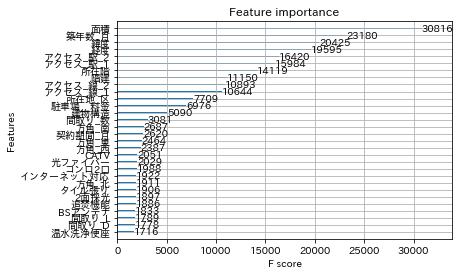

In [229]:
# plot feature importance
from xgboost import plot_importance
plt.figure(figsize=(20, 10))
plot_importance(model, max_num_features=30)
# plt.savefig("feature_importance_1.png")
plt.show()

In [230]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)


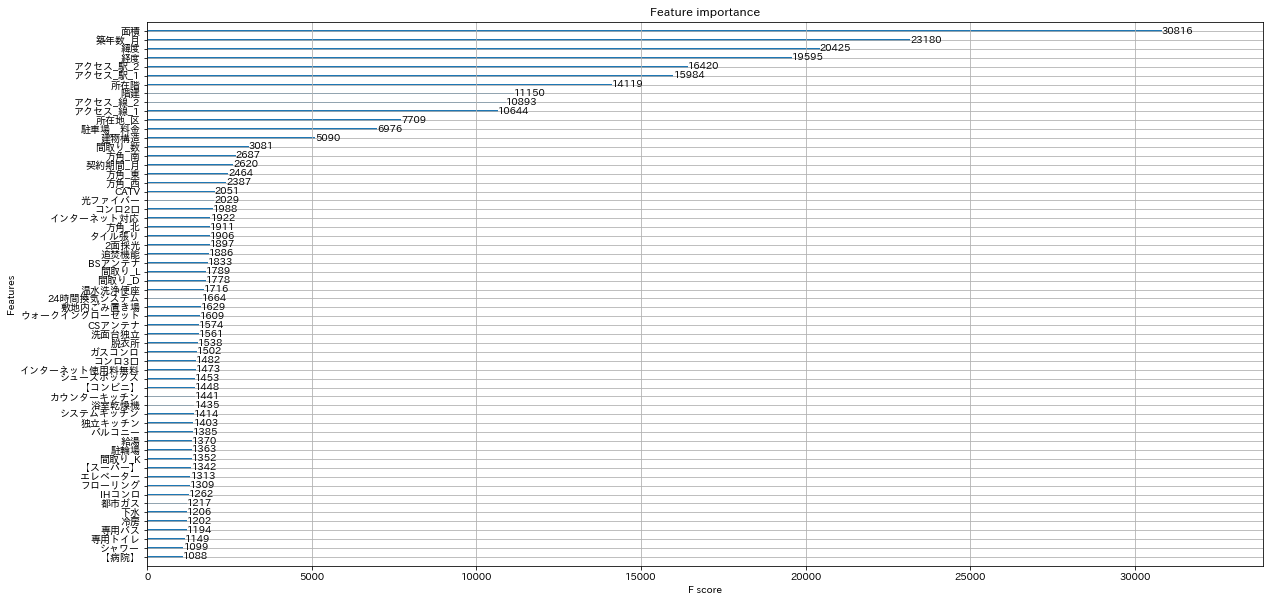

In [231]:
my_plot_importance(model, (20, 10), max_num_features=60)
plt.savefig("feature_importance_1.png")

In [234]:
print(model.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.8890139042078656, 'colsample_bynode': 1, 'colsample_bytree': 0.568440056710402, 'gamma': 0.002314443074501631, 'importance_type': 'gain', 'learning_rate': 0.10780341591905461, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 5200, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 0.001196420509187308, 'reg_lambda': 1.5838537725553767, 'scale_pos_weight': 1, 'seed': 0, 'silent': None, 'subsample': 0.5782191472704798, 'verbosity': 1, 'tree_method': 'gpu_hist'}
